<div style="font-variant: small-caps; 
  font-weight: normal; 
  font-size: 37px; 
  text-align: center; 
  padding: 15px; 
  margin: 10px;
  color: #ff69b4;">
  <span style="color: #ff69b4;">Machine Learning Project</span>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  -<br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px;
      color: #ff69b4;
      margin: 10px;">
      The executive code<br><br>
  </div> 


<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      MC 
  </div>

In [ ]:
%matplotlib inline

import copy
import np as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import  cross_val_score
import joblib

from maincode import *
from eclyon.transforms import process_df, split_vals

from sklearn.ensemble import RandomForestRegressor

import math

In [30]:
def metrics_result_n(y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    rec = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
    prc = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    spe = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0)
    f1 = 2 * (prc * rec) / (prc + rec)

    print('Accuracy : {:.2f}%'.format(acc * 100))
    print('Recall : {:.2f}%'.format(rec * 100))
    print('Precision : {:.2f}%'.format(prc * 100))
    print('Specificity : {:.2f}%'.format(spe * 100))
    print('F1-score : {:.2f}%'.format(f1 * 100))

In [3]:
df_clean = pd.read_csv('c:/Users/Melissa/Bureau/Bsc 2/ML/BITCOIN/ML-project/data/processed/clean_df.csv')
df_selected_17 = pd.read_csv('c:/Users/Melissa/Bureau/Bsc 2/ML/BITCOIN/ML-project/data/processed/selected_columns_17.csv')


In [5]:
df = pd.merge(df_selected_17, df_clean[['close']], left_index=True, right_index=True)



In [6]:
# Calculate relative evolution
df["Relative_Evolution"] = df["Evolution"] / df["close"]

# Calculate the moving average of the relative evolution
df['R_E_5'] = df['Relative_Evolution'].rolling(window=5, min_periods=1).mean()


# Transform R_E_5 in binary 
q25 = df["R_E_5"].quantile(0.25)
q75 = df["R_E_5"].quantile(0.75)

df["B-Evolution"] = np.where(df["R_E_5"] < q25, 0, np.where(df["R_E_5"] > q75, 2, 1))


df = df.drop(columns=['close'])

df["B-Evolution"]


0         0
1         0
2         1
3         0
4         1
         ..
416620    1
416621    1
416622    1
416623    0
416624    0
Name: B-Evolution, Length: 416625, dtype: int64

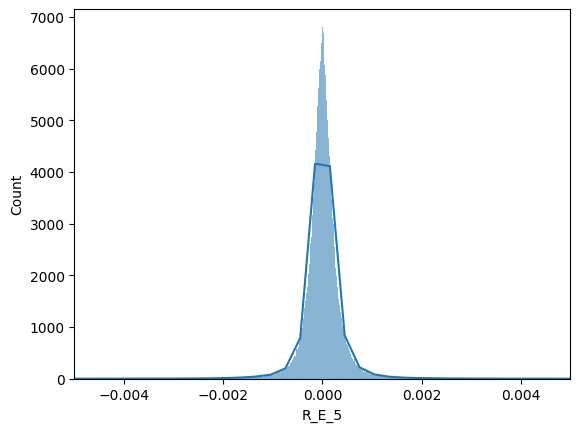

count    4.166250e+05
mean     7.325554e-07
std      5.002295e-04
min     -2.792629e-02
25%     -1.450952e-04
50%      1.186004e-06
75%      1.502093e-04
max      3.151306e-02
Name: R_E_5, dtype: float64


In [ ]:
data = df["R_E_5"]

sns.histplot(data=data, kde=True)
plt.xlim(-0.005, 0.005)
plt.show()

print(data.describe())



# Settings

In [10]:
df, y, nas = process_df(df, 'B-Evolution')

In [11]:
n_total = len(df)
# Calculate the number of validation samples
n_valid = int(n_total * 0.1)

# Calculate the number of training samples
n_train = n_total - n_valid

# Print the total number of samples, training samples, and validation samples
print(n_total, n_train, n_valid)

# Split the DataFrame into training and validation sets
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

# Select the first 10,000 samples from the training set for X and y
_, X_small = split_vals(X_train, n_train-10000)
_, y_small = split_vals(y_train, n_train-10000)


416625 374963 41662


# Model


In [15]:
classifier = RandomForestClassifier(
    n_estimators = 20, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

calibrated_classifier = CalibratedClassifierCV(
    estimator = classifier,
    method = 'sigmoid', # 'sigmoid' or 'isotonic'
    ensemble = True,
    cv = 5,
    n_jobs = -1,
)

In [ ]:
calibrated_classifier.fit(X_train, y_train)

y_predict_valid = calibrated_classifier.predict(X_valid)


In [ ]:
metrics_result_n(y_valid, y_predict_valid)

Accuracy : 94.18%
Recall : 100.00%
Precision : 91.90%
Specificity : 83.60%
F1-score : 95.78%


In [32]:
cv_scores = cross_val_score(calibrated_classifier, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.9932527  0.97557105 0.9610897  0.99203915 0.99199915]
Mean cross-validation score: 0.982790351201572


# Export

In [ ]:
joblib.dump(calibrated_classifier, 'c:/Users/Melissa/Bureau/Bsc 2/ML/BITCOIN/ML-project/models/calibrated_classifier.pkl')

['c:/Users/Melissa/Bureau/Bsc 2/ML/BITCOIN/ML-project/models/calibrated_classifier.pkl']